In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Nick Ouwerkerk\AppData\Local\Temp\ipykernel_6388\2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('../data/all_data.csv')

#### General information

In [3]:
#all column names starting with 'adres_recentste_wijk'
district_column_names = np.array([s for s in list(data.columns.values) if s.startswith('adres_recentste_wijk_')])

#full name of districts, order of districts is the same as district_column_names
district_full_names = np.array(['Charlois', 'Delfshaven', 'Feijenoord', 'Ijsselmonde', 'Kralingen-Crooswijk',
                       'Noord', 'Other', 'Prins Alexander', 'Stadscentrum'])

district_name_mapping = dict(zip(district_column_names, district_full_names))

#dataframe with only 'adres_recentste_wijk' info as columns
data_districts_only = data.filter(like='adres_recentste_wijk', axis=1)

#https://allecijfers.nl/gemeente-overzicht/rotterdam/ (2024)
inhabitants_per_district = {
    'Charlois': 70525,
    'Delfshaven': 77250,
    'Feijenoord': 79440,
    'Ijsselmonde': 62670,
    'Kralingen-Crooswijk': 56010,
    'Noord': 52795,
    'Other': 131855,
    'Prins Alexander': 97430,
    'Stadscentrum': 42565,
}

print(f'Total amount of rows: \t\t\t {data_districts_only.shape[0]}')
print(f'Amount of rows not assigned a district:  {(data_districts_only.sum(axis=1) == 0).sum()}')
print(district_column_names)

Total amount of rows: 			 130000
Amount of rows not assigned a district:  37752
['adres_recentste_wijk_charlois' 'adres_recentste_wijk_delfshaven'
 'adres_recentste_wijk_feijenoord' 'adres_recentste_wijk_ijsselmonde'
 'adres_recentste_wijk_kralingen_c' 'adres_recentste_wijk_noord'
 'adres_recentste_wijk_other' 'adres_recentste_wijk_prins_alexa'
 'adres_recentste_wijk_stadscentru']


#### Data distribution over districts

In [4]:
# count number of fraud checks for each district and in total
data_district_counts = data_districts_only.sum(axis=0)
data_total_count = data_district_counts.sum(axis=0)

data_district_percentages = (data_district_counts / data_total_count) * 100.0
print(data_district_percentages)

adres_recentste_wijk_charlois       15.018212
adres_recentste_wijk_delfshaven     19.210173
adres_recentste_wijk_feijenoord     24.412453
adres_recentste_wijk_ijsselmonde     5.956769
adres_recentste_wijk_kralingen_c     6.246206
adres_recentste_wijk_noord           2.962666
adres_recentste_wijk_other          18.847021
adres_recentste_wijk_prins_alexa     5.514483
adres_recentste_wijk_stadscentru     1.832018
dtype: float64


#### Inhabitant distribution over districts

In [5]:
# Distribution on inhabitants per district
inhabitants_array = np.array([inhabitants_per_district[district] for district in district_full_names])
inhabitants_district_percentages = (inhabitants_array / np.sum(inhabitants_array)) * 100.0

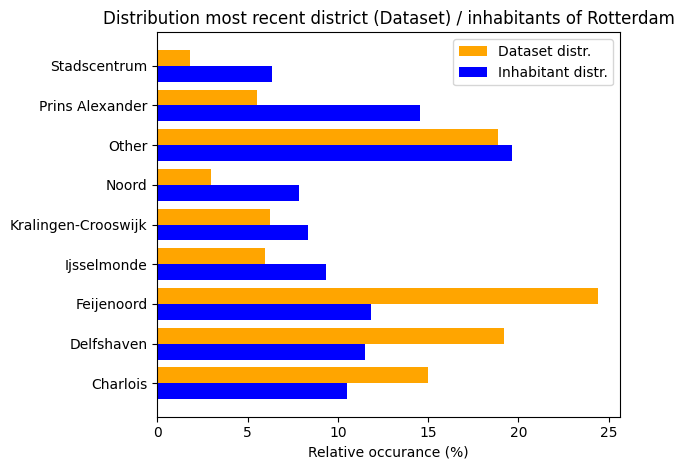

In [6]:
y_pos = np.arange(len(district_full_names))

plt.barh(y_pos, data_district_percentages, height=0.4, label='Dataset distr.', color='orange')

# Plot the second horizontal bar plot, slightly offset vertically
plt.barh(y_pos - 0.4, inhabitants_district_percentages, height=0.4, label='Inhabitant distr.', color='blue')

plt.yticks(y_pos - 0.2, district_full_names)  # Center labels between the two bars
plt.xlabel('Relative occurance (%)')
plt.title('Distribution most recent district (Dataset) / inhabitants of Rotterdam')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
#current distribution of fraud checks per district
current_distribution = dict(zip(district_full_names, data_district_percentages))

#target distribution of inhabitants per district
target_distribution = dict(zip(district_full_names, inhabitants_district_percentages))

#calculated weights for each district
weights_per_district = {district: target_distribution[district] / current_distribution[district] for district in district_full_names}
weights_per_district['no district'] = 1.0

#map column names to actual names while leaving 'no district' the same
district_name_per_row = data_districts_only.idxmax(axis=1).where(data.sum(axis=1) > 0, 'no district').apply(lambda x: district_name_mapping.get(x, x))
weights_per_row = district_name_per_row.map(weights_per_district)
print(weights_per_row)

0         0.485292
1         2.657574
2         1.043348
3         0.485292
4         0.485292
            ...   
129995    0.700326
129996    0.700326
129997    0.599712
129998    0.485292
129999    0.700326
Length: 130000, dtype: float64


In [8]:
weights_per_row.to_csv('../weights/district_weights_per_row.csv', index=False, header=False)

In [16]:
from scipy.stats import wilcoxon

print(data_district_percentages.to_numpy() / 100.0)
print(inhabitants_district_percentages / 100.0)
stat, p = wilcoxon(data_district_percentages.to_numpy() / 100.0, inhabitants_district_percentages / 100.0)

print("Test Statistic:", stat)
print("p-value:", p)

# Interpretation
alpha = 0.05  # significance level
if p < alpha:
    print("There is a significant difference between the two groups.")
else:
    print("No significant difference; any variation is likely due to chance.")

[0.15018212 0.19210173 0.24412453 0.05956769 0.06246206 0.02962666
 0.18847021 0.05514483 0.01832018]
[0.10517642 0.11520566 0.11847168 0.09346199 0.08352969 0.07873505
 0.19664002 0.1453008  0.06347869]
Test Statistic: 20.0
p-value: 0.8203125
No significant difference; any variation is likely due to chance.


In [1]:
from scipy.stats import chisquare

# Given distributions
distr1 = np.array([0.15018212, 0.19210173, 0.24412453, 0.05956769, 0.06246206, 0.02962666, 0.18847021, 0.05514483, 0.01832018])
distr2 = np.array([0.10517642, 0.11520566, 0.11847168, 0.09346199, 0.08352969, 0.07873505, 0.19664002, 0.1453008, 0.06347869])

# Assume a hypothetical sample size (e.g., 1000 for both distributions)
sample_size = 1000
obs = distr1 * sample_size
exp = distr2 * sample_size

# Perform Chi-Square test
chi2_stat, p_value = chisquare(f_obs=obs, f_exp=exp)

# Output results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret results
if p_value < 0.05:
    print("The distributions are statistically different.")
else:
    print("No significant difference between the distributions.")

NameError: name 'np' is not defined